In [2]:
import os
import cv2

def extract_faces(video_path, output_folder, max_frames=300):
    # Create folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Load pre-trained face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    success, frame = cap.read()
    count = 0

    # Extract faces from frames and save them
    while success and count < max_frames:
        # Convert frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the frame
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Save each detected face
        for (x, y, w, h) in faces:
            face = frame[y:y+h, x:x+w]
            face_path = os.path.join(output_folder, f"face_{count}.jpg")
            cv2.imwrite(face_path, face)
            count += 1
            if count >= max_frames:
                break  # Stop extraction if max_frames limit is reached

        success, frame = cap.read()

    cap.release()


In [3]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.color import rgb2gray
from tensorflow.keras.models import load_model

def load_frames(video_folder, target_size=(150, 150)):
    frames = []
    for frame_name in os.listdir(video_folder):
        frame_path = os.path.join(video_folder, frame_name)
        # Load frame and preprocess
        frame = load_img(frame_path, target_size=target_size)
        frame_array = img_to_array(frame) / 255.0  # Normalize pixel values
        frames.append(frame_array)
    return np.array(frames)
def load_frames_seq(video_folder, target_size=(150, 150)):
    frames = []
    for frame_name in os.listdir(video_folder):
        frame_path = os.path.join(video_folder, frame_name)
        # Load frame and preprocess
        frame = load_img(frame_path, target_size=target_size)
        
        frame_array = img_to_array(frame)
        frame_array_gray = rgb2gray(frame_array)
        frames.append(frame_array_gray)
    return np.array(frames)

extract_faces(r"D:/mini/testing_final/id0_0003.mp4", r"D:/mini/testing_final/out_real")
# Load your trained model


# Folder containing frames of the video to be tested
video_folder = r"D:/mini/testing_final/out_real"

# Perform prediction
x_train=load_frames(video_folder)
x_train_seq=load_frames_seq(video_folder)



In [4]:
model = load_model("D:\mini\model.h5")
predictions = model.predict([x_train,x_train_seq])
    # Calculate average prediction score
avg_score = np.mean(predictions)
    # Define threshold for decision-making
threshold = 0.5  # Adjust as needed
    # Make decision
if avg_score >= threshold:
    print("Fake")
else:
    print("Real")

17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 534ms/step
Real


In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

def generate_grad_cam(model, img_array, lstm_input_array, last_conv_layer_name, pred_index=None):
    # Create a Grad-CAM model that outputs the last convolutional layer and the final predictions
    grad_model = tf.keras.models.Model(
        [model.input[0], model.input[1]],  # EfficientNetB0 input and LSTM input
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        # Forward pass through the Grad-CAM model
        conv_outputs, predictions = grad_model([img_array, lstm_input_array])
        
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # Pick the most likely class
        
        # Output the probability of the predicted class
        class_channel = predictions[:, pred_index]
    
    # Get the gradient of the predicted class wrt. the output feature map of the last conv layer
    grads = tape.gradient(class_channel, conv_outputs)

    # Take the mean of the gradients along the depth axis (channels)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the output feature map with the computed gradients
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0 and 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    
    return heatmap  # No .numpy() needed


# Function to display the Grad-CAM heatmap on top of the original image
def display_grad_cam(heatmap, original_img, alpha=0.6):
    # Resize the heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

    # Convert the heatmap to RGB (3 channels)
    heatmap = np.uint8(255 * heatmap)

    # Convert heatmap to BGR (OpenCV uses BGR by default)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Ensure original image is in float32 for blending
    if original_img.dtype == np.uint8:
        original_img = np.float32(original_img) / 255.0

    # Superimpose the heatmap on the original image
    superimposed_img = heatmap * alpha + original_img

    # Convert the superimposed image to uint8 format
    superimposed_img = np.uint8(255 * superimposed_img)

    # Display the superimposed image
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [ ]:
last_conv_layer_name = "block7a_project_conv"  # EfficientNetB0's last conv layer
for i, (frame, lstm_seq) in enumerate(zip(x_train, x_train_seq)):
    # Expand dimensions to match the model input format
    img_array = np.expand_dims(frame, axis=0)
    lstm_input_array = np.expand_dims(lstm_seq, axis=0)

    # Generate Grad-CAM heatmap for the current frame
    heatmap = generate_grad_cam(model, img_array, lstm_input_array, last_conv_layer_name)
    
    # Display the Grad-CAM heatmap on the original frame
    frame_original = cv2.imread(os.path.join(video_folder, f"face_{i}.jpg"))
    display_grad_cam(heatmap, frame_original)


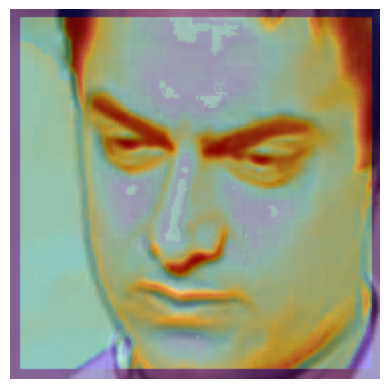

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def save_grad_cam(heatmap, original_img, output_path, alpha=0.6):
    # Resize heatmap to match the size of the original image
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

    # Normalize the heatmap between 0 and 255
    heatmap = np.uint8(255 * heatmap)

    # Apply a color map on the heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image with transparency
    superimposed_img = heatmap * alpha + original_img

    # Normalize and convert the result to uint8 for saving
    superimposed_img = np.uint8(255 * superimposed_img / np.max(superimposed_img))

    # Save the resulting image
    cv2.imwrite(output_path, superimposed_img)

    # Display the final image
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Example usage:
original_image = cv2.imread(r"D:/mini/testing_final/out_real/face_0.jpg")  # Replace with your original image path
heatmap = cv2.imread(r"D:/mini/heatmap-1.png", cv2.IMREAD_GRAYSCALE)  # Replace with your heatmap path
save_grad_cam(heatmap, original_image, "output_image_with_cam.jpg")
